This is the code used in the handwritten digits generator example of the article [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/) on Real Python.

In [1]:
from IPython.core.debugger import set_trace

In [2]:
import torch
from torch import nn, optim

import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

In [3]:
torch.manual_seed(111)

In [4]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [6]:
train_set = torchvision.datasets.MNIST(root='.',
                                      train=True,
                                      download=True,
                                      transform=transform)


In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

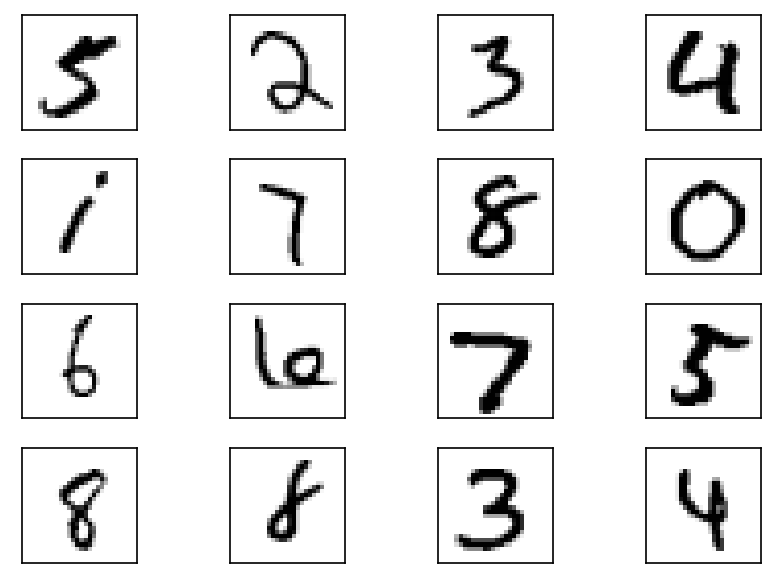

In [8]:
plt.figure(dpi=150)
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()    

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        #x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [12]:
generator = Generator().to(device=device)

In [13]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [14]:
latent_space_samples_plot = torch.randn((16, 100)).to(device=device)

In [15]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):
            # Data for training the discriminator
            real_samples = real_samples.to(device=device)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros(
                (batch_size, 1)).to(device=device)
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat(
                (real_samples_labels, generated_samples_labels))

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(
                output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()
        
            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Training the generator            
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(
                output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()

            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")

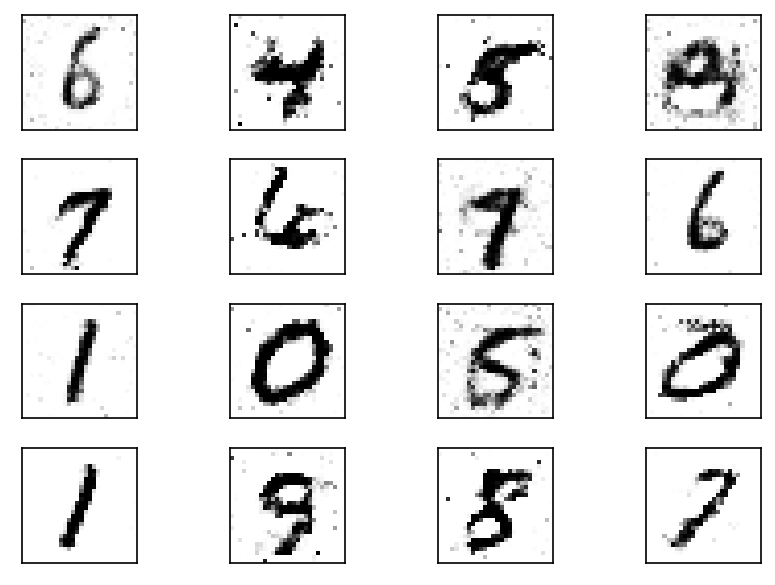

In [16]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [17]:
# Save trained NN parameters
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')